<a href="https://www.kaggle.com/code/danuherath/academic-success-classification?scriptVersionId=188062215" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center"> Academic Success Prediction (Multi Class Classification) </h1>

<img 
    src="https://www.kaggle.com/competitions/73290/images/header" 
    alt="" 
    width="300" 
    height="150" 
    style="display: block; margin: 0 auto" 
/>

---

## Problem Definition

- Domain    
    
    - Education (Higher Education)
    
<br>

- Dataset
    
    - [Classification with an Academic Success Dataset](https://www.kaggle.com/competitions/playground-series-s4e6/data) by Kaggle. The dataset contains 36 features that explains students' demographics, academic background, family background etc. Train dataset comprises 76,518 samples and each instance in the dataset represents one student.

<br>

- Objective
    
    - The goal of this project is to predict academic risk of students in higher education. This is a multi-class classification problem which requires to predict target varaible as 'Graduate', 'Dropout', or 'Enrolled'.

<br>

- Algorithms

    - Following classification algorithms are used to train models. The models are evaluated using the accuracy score.
    
        1. [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
        2. [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)
        3. [LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
        4. [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)
    
<br>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score

import optuna

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')


In [3]:
print(f"Train Data\nInstance Count: {train_data.shape[0]} \nColumn Count: {train_data.shape[1]}")
train_data.head().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"'
    ).set_properties(**{'min-width': '50px'})


Train Data
Instance Count: 76518 
Column Count: 38


,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.000000,1,1,19,5,5,122.600000,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.100000,0.600000,2.020000,Graduate
1,1,1,17,1,9238,1,1,125.000000,1,19,19,9,9,119.800000,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.100000,0.600000,2.020000,Dropout
2,2,1,17,2,9254,1,1,137.000000,1,3,19,2,3,144.700000,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.200000,0.300000,-0.920000,Dropout
3,3,1,1,3,9500,1,1,131.000000,1,19,3,3,2,126.100000,1,0,0,1,0,1,18,0,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.100000,0.600000,2.020000,Enrolled
4,4,1,1,2,9500,1,1,132.000000,1,19,37,4,9,120.100000,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.600000,2.600000,0.320000,Graduate


In [4]:
print(f"Test Data\nInstance Count: {test_data.shape[0]} \nColumn Count: {test_data.shape[1]}")

test_data.head().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"'
    ).set_properties(**{'min-width': '50px'})


Test Data
Instance Count: 51012 
Column Count: 37


,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,76518,1,1,1,9500,1,1,141.000000,1,3,1,2,3,152.100000,0,0,0,0,0,0,18,0,0,7,0,0,0.000000,0,0,8,0,0,0.000000,0,13.900000,-0.300000,0.790000
1,76519,1,1,1,9238,1,1,128.000000,1,1,19,4,5,116.500000,0,0,0,1,0,0,19,0,0,6,7,6,14.857143,0,0,6,6,6,13.500000,0,11.100000,0.600000,2.020000
2,76520,1,1,1,9238,1,1,118.000000,1,1,19,4,9,114.200000,0,0,0,1,0,1,18,0,0,6,11,6,12.000000,0,0,6,11,5,11.000000,0,15.500000,2.800000,-4.060000
3,76521,1,44,1,9147,1,39,130.000000,1,1,19,3,3,130.000000,0,0,0,1,0,1,23,0,2,6,15,5,11.500000,0,3,8,14,5,11.000000,0,8.900000,1.400000,3.510000
4,76522,1,39,1,9670,1,1,110.000000,1,1,37,5,5,106.000000,1,0,0,1,0,0,26,0,0,6,9,3,11.000000,0,0,6,9,4,10.666667,2,7.600000,2.600000,0.320000


---

# Step 1: Exploratory Data Analysis (EDA)

---

In [5]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [6]:
test_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51012 entries, 0 to 51011
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              51012 non-null  int64  
 1   Marital status                                  51012 non-null  int64  
 2   Application mode                                51012 non-null  int64  
 3   Application order                               51012 non-null  int64  
 4   Course                                          51012 non-null  int64  
 5   Daytime/evening attendance                      51012 non-null  int64  
 6   Previous qualification                          51012 non-null  int64  
 7   Previous qualification (grade)                  51012 non-null  float64
 8   Nacionality                                     51012 non-null  int64  
 9   Mother's qualification                 

In [7]:
print(f"Train data null value count: {train_data.isnull().sum().sum()}")
print(f"Test data null value count: {test_data.isnull().sum().sum()}")     


Train data null value count: 0
Test data null value count: 0


In [8]:
duplicates = train_data[train_data.duplicated(keep=False)]
print(len(duplicates))


0


### Conclusion:

- There are no null values in both train and test datasets.
- There are no missing values in both train and test datasets.
- There are no duplicated rows in train dataset.

---

In [9]:
unique_value_counts = {}
cat_features = []
num_features = []

for col in train_data.columns:
    unique_values = train_data[col].unique()
    value_counts = train_data[col].value_counts()
    unique_value_counts[col] = {'unique_values': unique_values, 'value_counts': value_counts}

for col, values_counts in unique_value_counts.items():
#     print(f"Column '{col}':")
#     print(f"Unique values: {values_counts['unique_values']}")
#     print(f"Value counts:")
#     print(values_counts['value_counts'])
#     print()
    if len(values_counts['unique_values']) < 10:
        cat_features.append(col)
    else: 
        num_features.append(col)
        
        
print("Categorical Features: \n", cat_features, "\n")
print("Numerical Features: \n", num_features, "\n")


Categorical Features: 
 ['Marital status', 'Application order', 'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International', 'Target'] 

Numerical Features: 
 ['id', 'Application mode', 'Course', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Une

In [10]:
cat_features = [
    "Marital status",
    "Application mode",
    "Application order",
    "Course",
    "Daytime/evening attendance",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International"
]

num_features = list(train_data.drop(cat_features, axis=1).columns)
num_features.remove('id')
num_features.remove('Target')


print(f"Categorical Feature Count: {len(cat_features)}")
print(f"Numerical Feature Count: {len(num_features)}")

print(f"\nCategorical Features: {cat_features}")
print(f"\nNumerical Features: {num_features}")

Categorical Feature Count: 18
Numerical Feature Count: 18

Categorical Features: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']

Numerical Features: ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular unit

### Conclusion:

- Though all features have numerical values, some features should be identified as categorical features.
- Accordngly, there are 18 categorical features and 18 numerical features.
---


---

## 1.1 Statistical Analysis

---

In [11]:
train_data[num_features].describe().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"').set_properties(**{'min-width': '100px'})


,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,132.378766,125.363971,22.278653,0.188871,5.891516,7.352362,4.178520,9.995862,0.057960,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,10.995328,12.562328,6.889241,1.175296,1.671776,3.508292,2.687995,5.264224,0.408490,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,95.000000,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,125.000000,118.000000,18.000000,0.000000,5.000000,6.000000,2.000000,10.666667,0.000000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,133.100000,124.600000,19.000000,0.000000,6.000000,7.000000,5.000000,12.166667,0.000000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,140.000000,132.000000,23.000000,0.000000,6.000000,9.000000,6.000000,13.314286,0.000000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,190.000000,190.000000,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


In [12]:
Q1 = train_data[num_features].quantile(0.25)
Q3 = train_data[num_features].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((train_data[num_features] < lower_bound) | (train_data[num_features] > upper_bound))

outliers_count = outliers_iqr.sum()
outliers_count = outliers_count[outliers_count > 0].sort_values(ascending=False)
print(f"Outliers Count: \n{outliers_count}")


columns_with_outliers = outliers_iqr.any()
columns_with_no_outliers = ~columns_with_outliers

# filtered_data = train_data[num_features].loc[:, columns_with_no_outliers]
# print(filtered_data)


Outliers Count: 
Curricular units 2nd sem (grade)                  18482
Curricular units 1st sem (grade)                  16059
Curricular units 2nd sem (enrolled)               14416
Curricular units 2nd sem (evaluations)            11254
Curricular units 1st sem (evaluations)            10692
Curricular units 1st sem (enrolled)                9135
Age at enrollment                                  8935
Curricular units 1st sem (credited)                3089
Curricular units 2nd sem (credited)                2709
Admission grade                                    2577
Curricular units 1st sem (without evaluations)     2449
Curricular units 2nd sem (without evaluations)     2146
Previous qualification (grade)                     1364
Curricular units 1st sem (approved)                 293
Curricular units 2nd sem (approved)                  61
dtype: int64


---

## 1.2 Data Visualization

---

---
## 1.2.1 Univariate Analysis
---

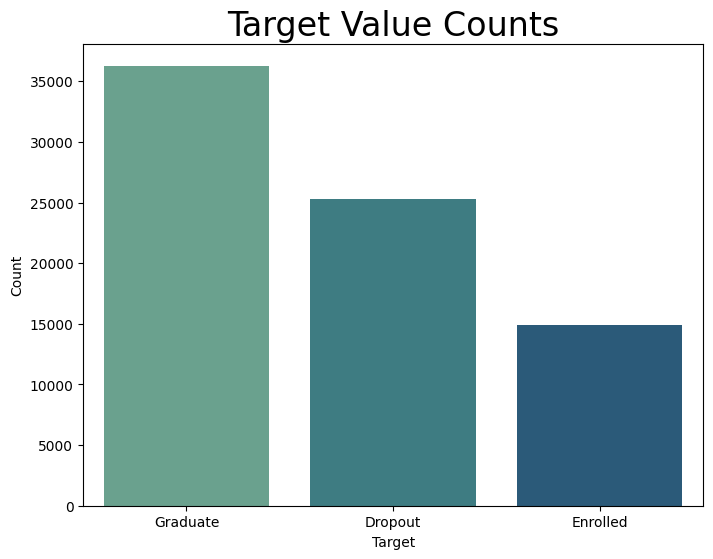

In [13]:
target_counts = train_data['Target'].value_counts()

plt.figure(figsize=(8,6))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='crest')
plt.ylabel('Count')
plt.title('Target Value Counts', fontsize=24)
plt.savefig("target count.png")
plt.show()



In [14]:
cat_features_short = []
cat_features_long = []


for col in cat_features:
    if train_data[col].nunique() < 10:
        cat_features_short.append(col)
    else:
        cat_features_long.append(col)

print(cat_features_short, '\n', cat_features_long)

['Marital status', 'Application order', 'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'] 
 ['Application mode', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation"]


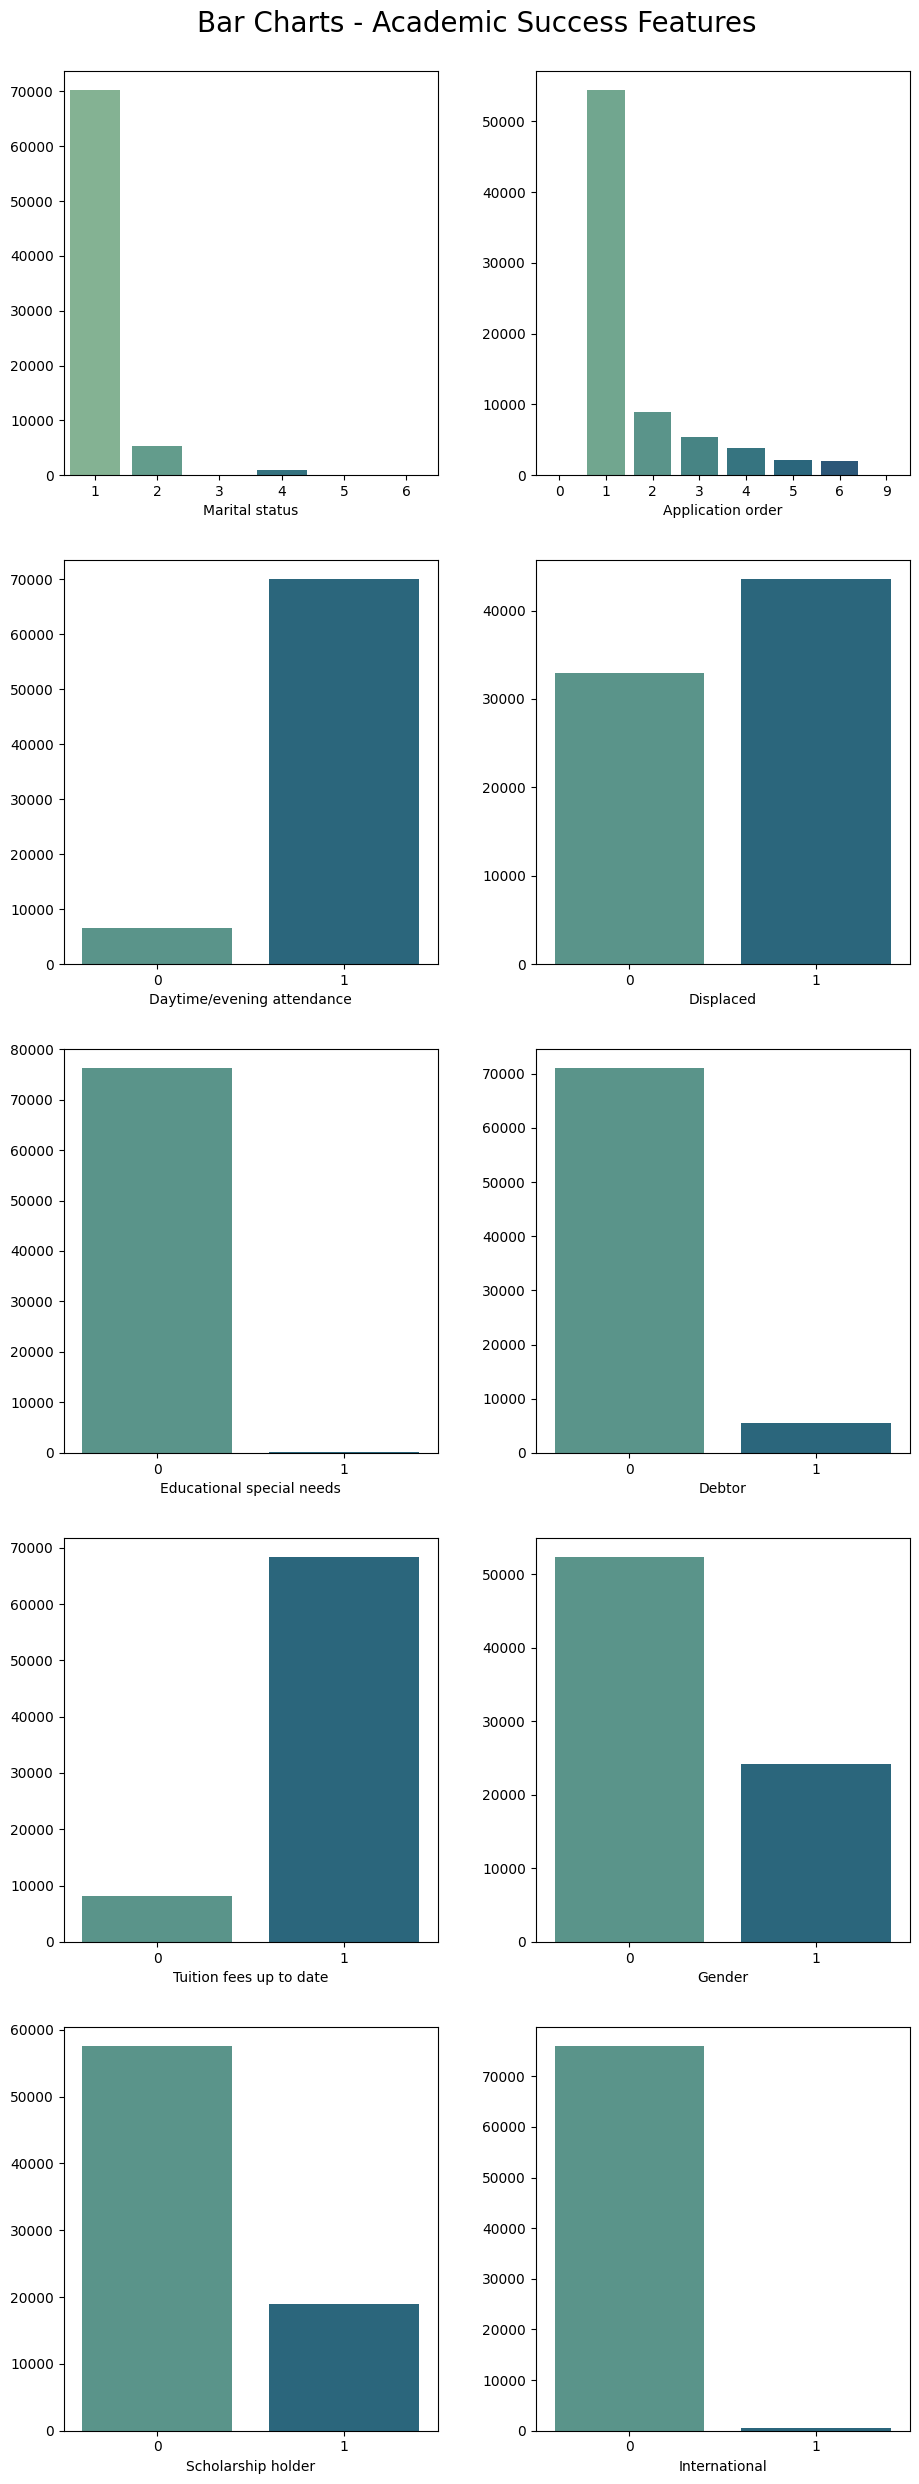

In [15]:
n_rows = 5
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5*n_rows))
fig.tight_layout(pad=4.0)

for i, column in enumerate(train_data[cat_features_short].columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    category_counts = train_data[cat_features_short][column].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, palette='crest')

plt.suptitle('Bar Charts - Academic Success Features', fontsize=20, y=1.0)
plt.savefig("categorical feature analysis 1.png")
plt.show()


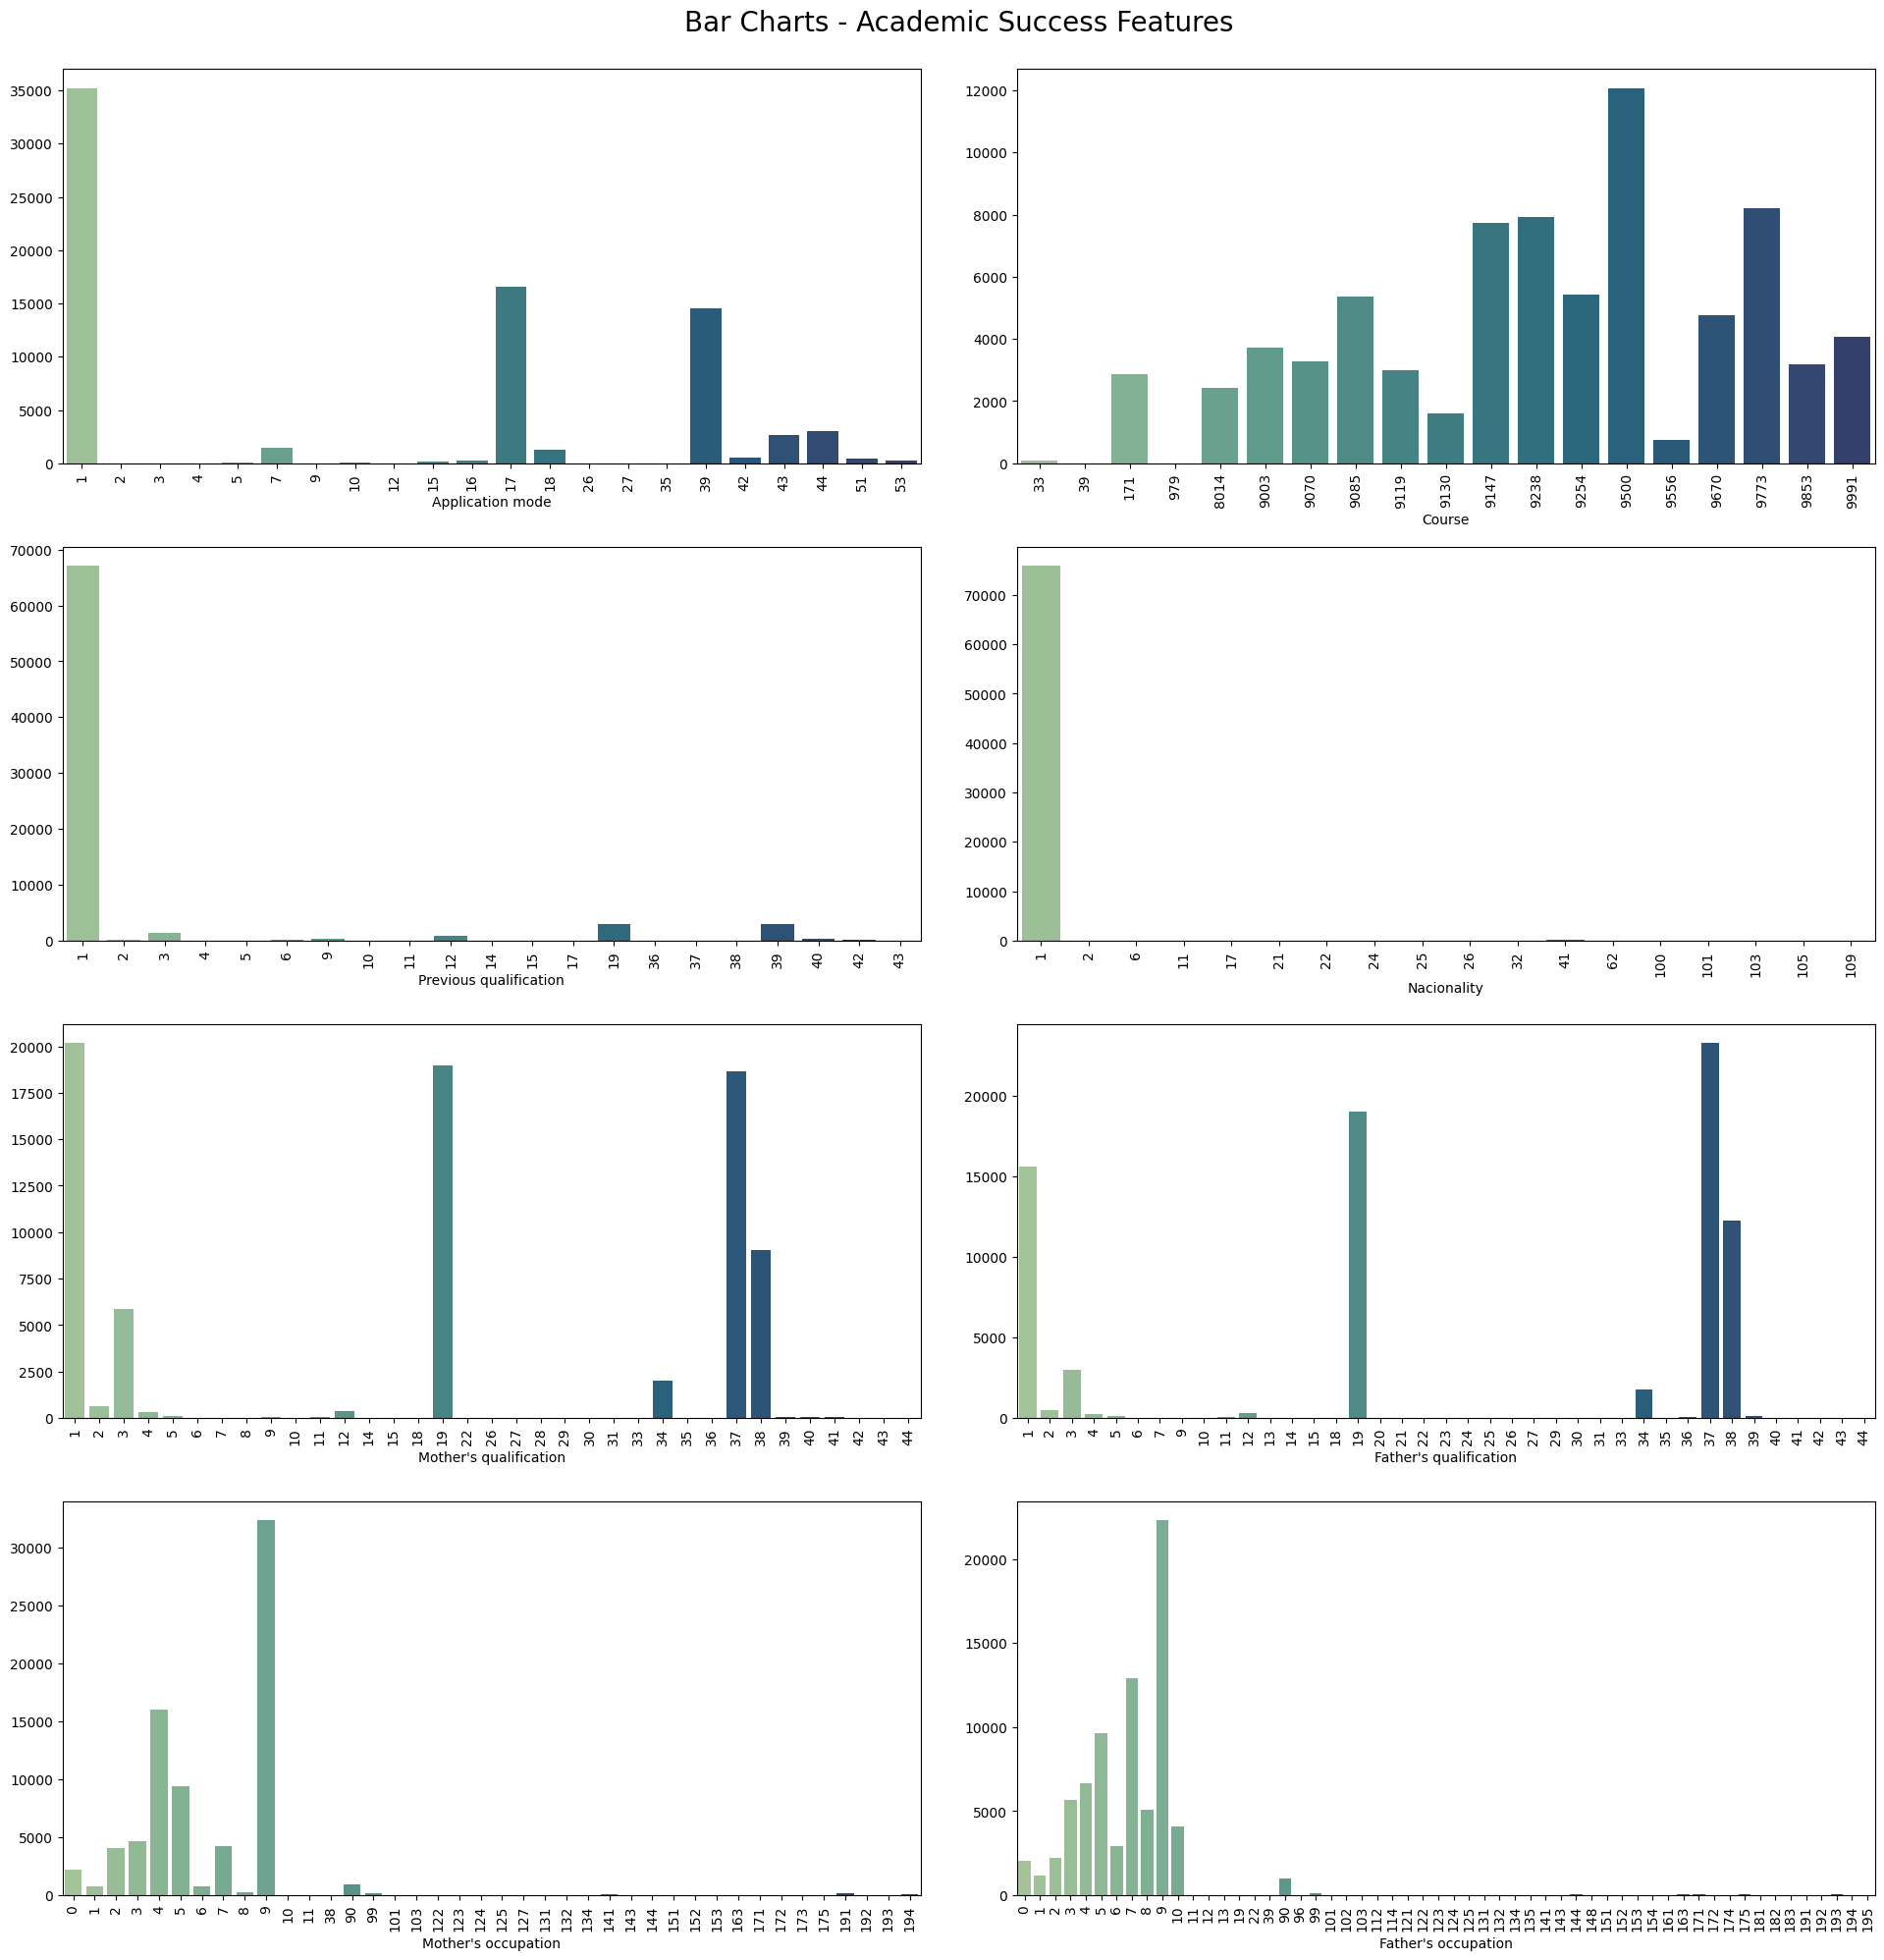

In [16]:
n_rows = 4
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,5*n_rows))
fig.tight_layout(pad=4.0)

for i, column in enumerate(train_data[cat_features_long].columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    category_counts = train_data[cat_features_long][column].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, palette='crest')

    ax.tick_params(axis='x', rotation=90)

plt.suptitle('Bar Charts - Academic Success Features', fontsize=20, y=1.0)    
plt.savefig("categorical feature analysis 2.png")
plt.show()


In [17]:
num_features_1 = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Unemployment rate', 'Inflation rate', 'GDP']
num_features_2 = [
    'Curricular units 1st sem (credited)', 'Curricular units 2nd sem (credited)',
    'Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)', 
    'Curricular units 1st sem (evaluations)', 'Curricular units 2nd sem (evaluations)',
    'Curricular units 1st sem (approved)', 'Curricular units 2nd sem (approved)',
    'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)',
    'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (without evaluations)'
]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

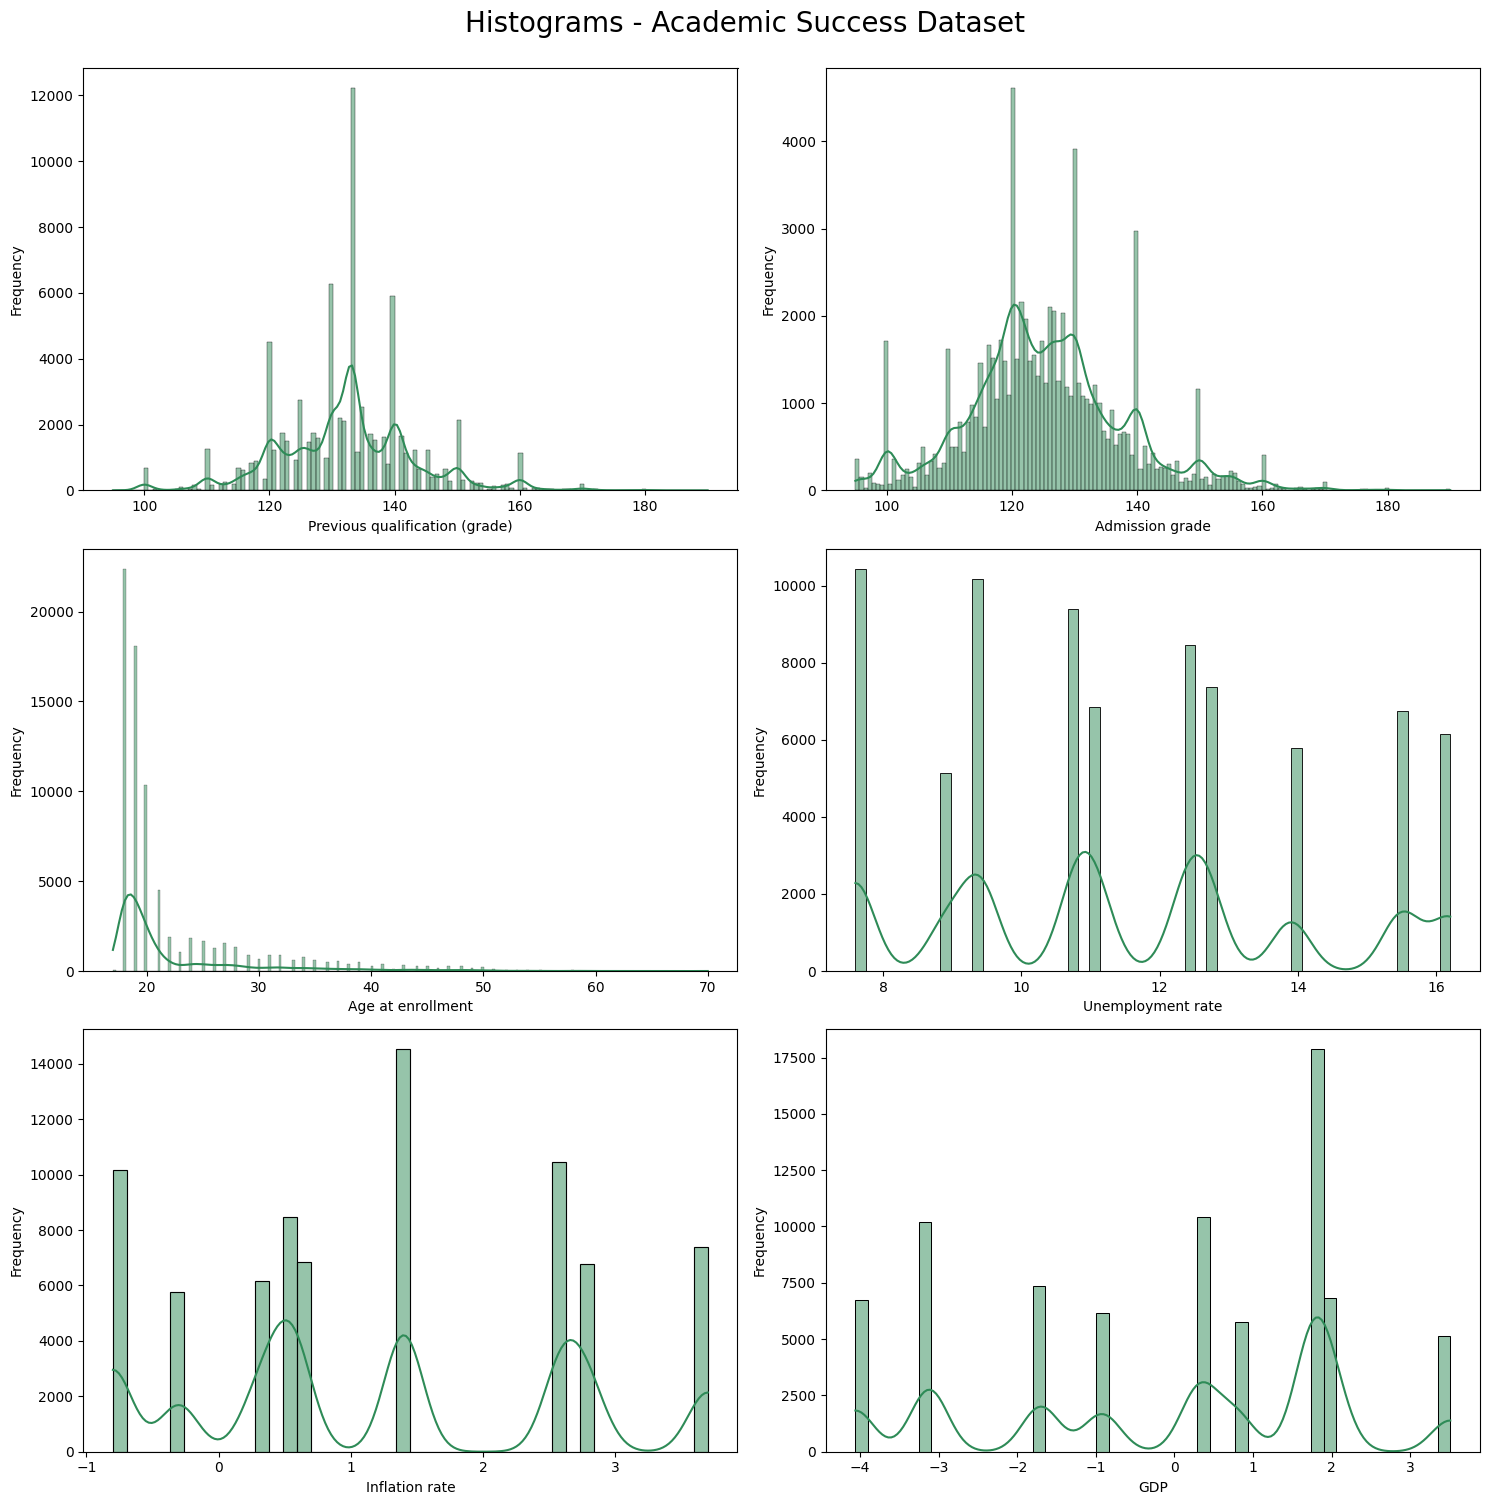

In [18]:
n_cols = 2
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()


for i, col in enumerate(train_data[num_features_1].columns):
    ax = axes[i]
    sns.histplot(train_data[num_features_1][col], kde=True, ax=ax, color='seagreen')
    ax.set_ylabel('Frequency')

plt.suptitle('Histograms - Academic Success Dataset', fontsize=20, y=1.0)
plt.tight_layout()
plt.savefig('numerical feature analysis 1.png')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

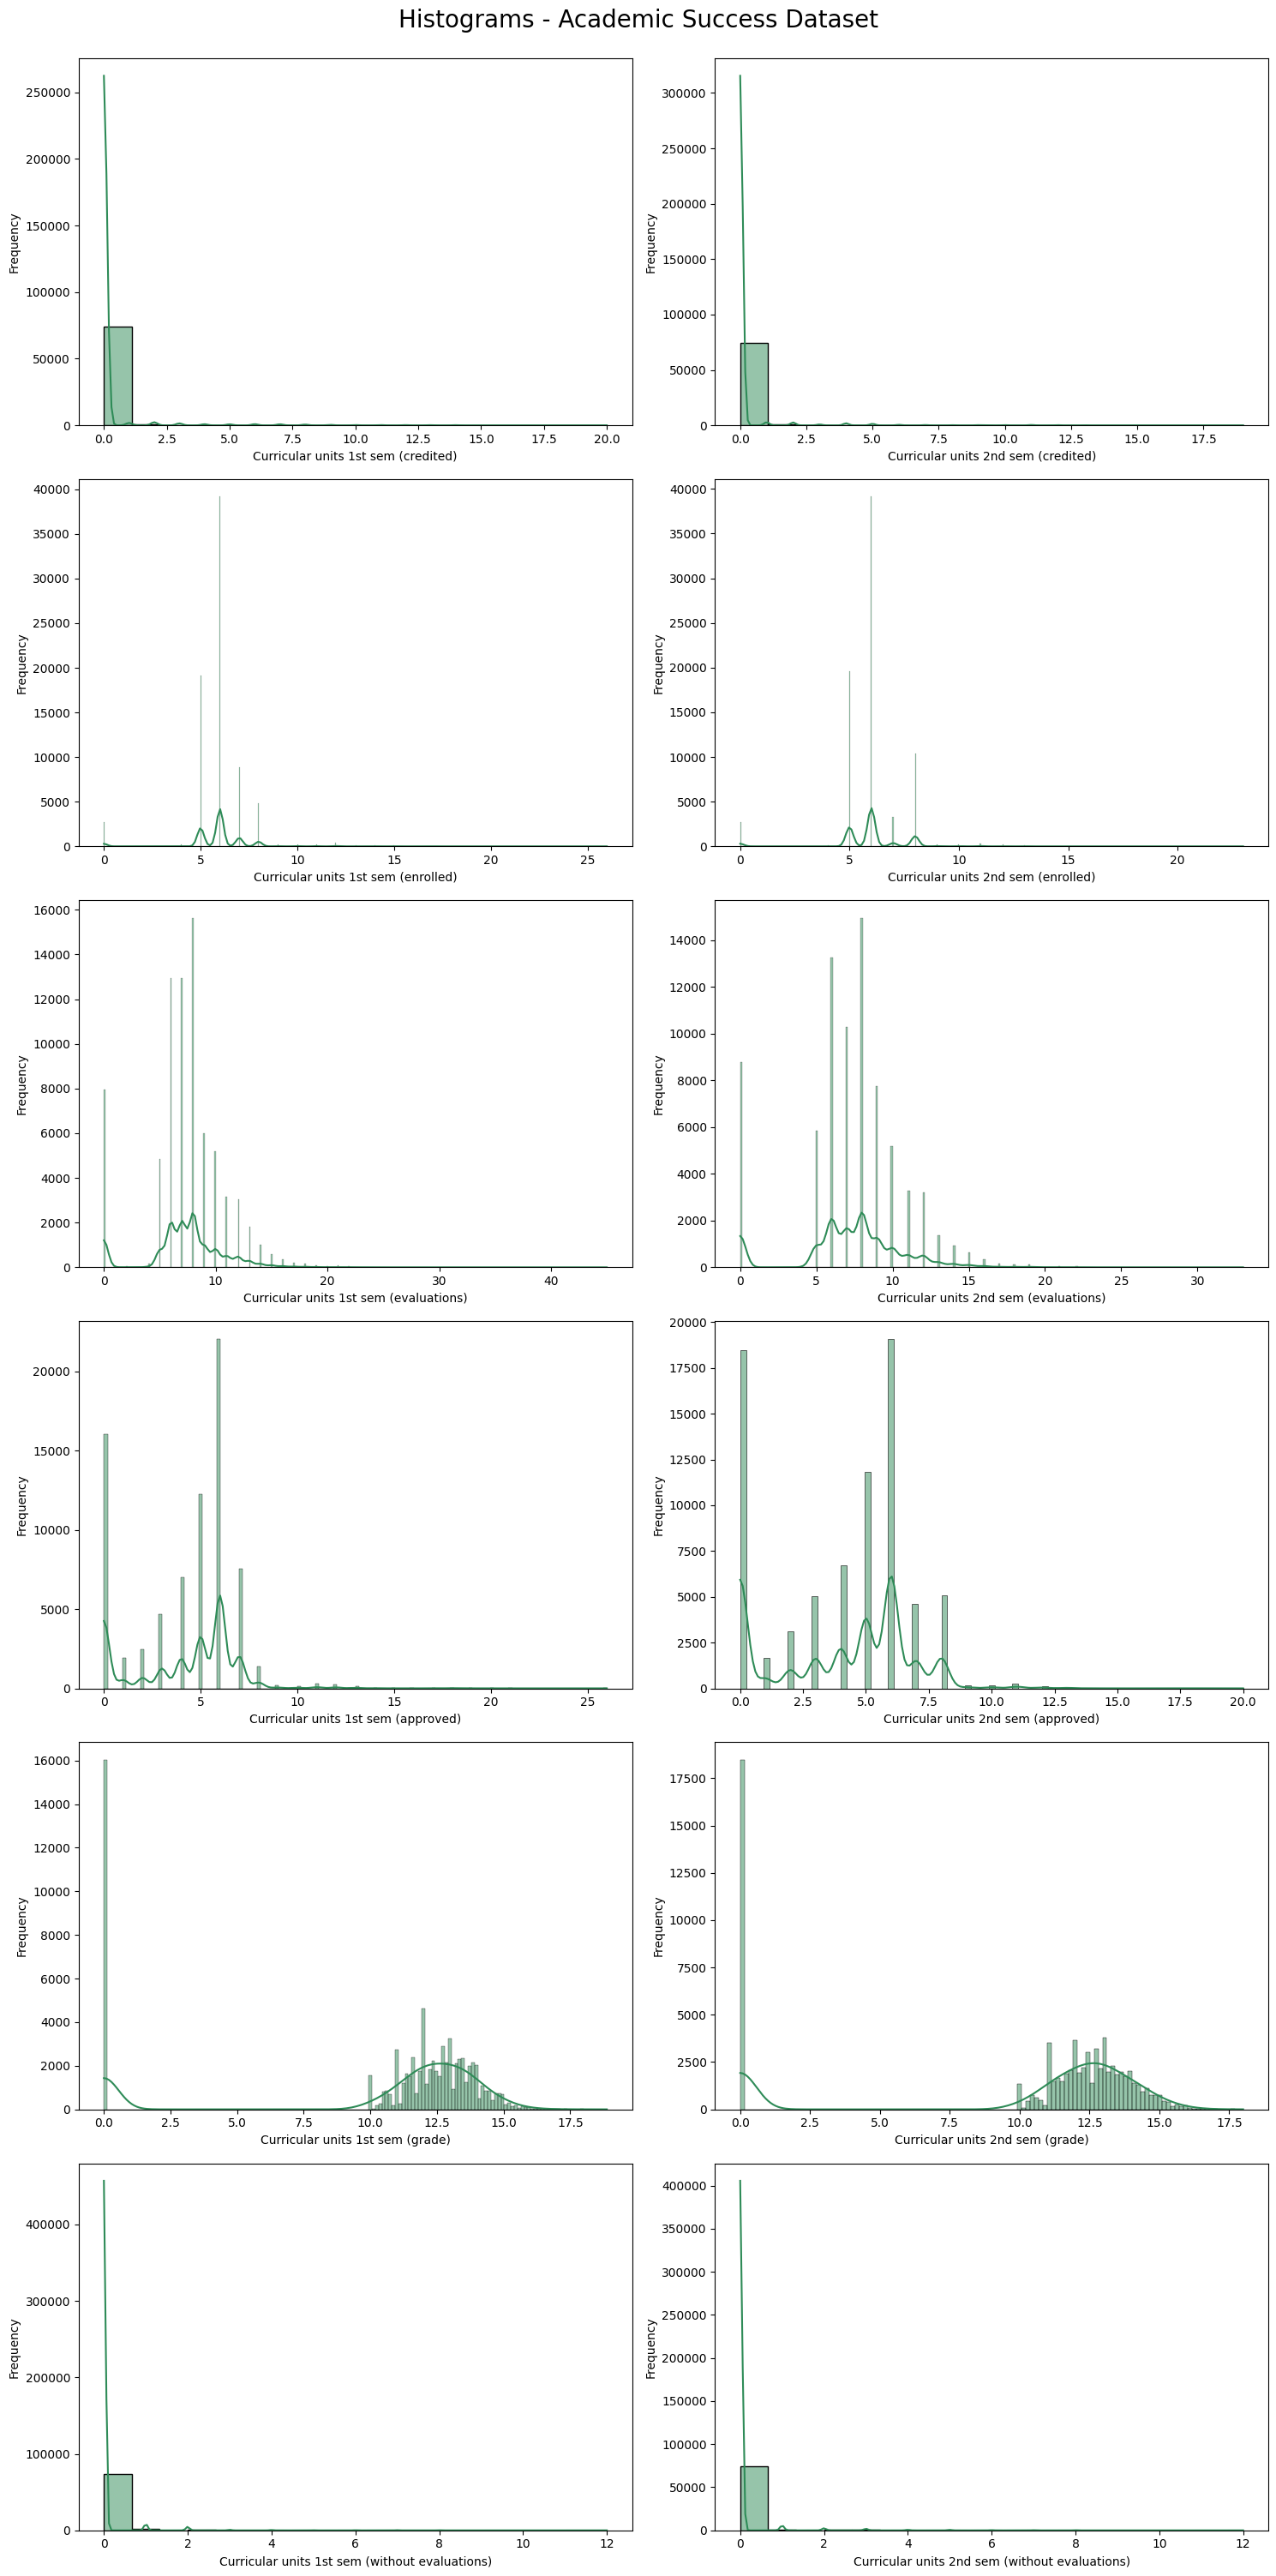

In [19]:
n_cols = 2
n_rows = 6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()


for i, col in enumerate(train_data[num_features_2].columns):
    ax = axes[i]
    sns.histplot(train_data[num_features_2][col], kde=True, ax=ax, color='seagreen')
    ax.set_ylabel('Frequency')

plt.suptitle('Histograms - Academic Success Dataset', fontsize=20, y=1.0)
plt.tight_layout()
plt.savefig('numerical feature analysis 2.png')
plt.show()


## 1.2.2 Bivariate Analysis
---

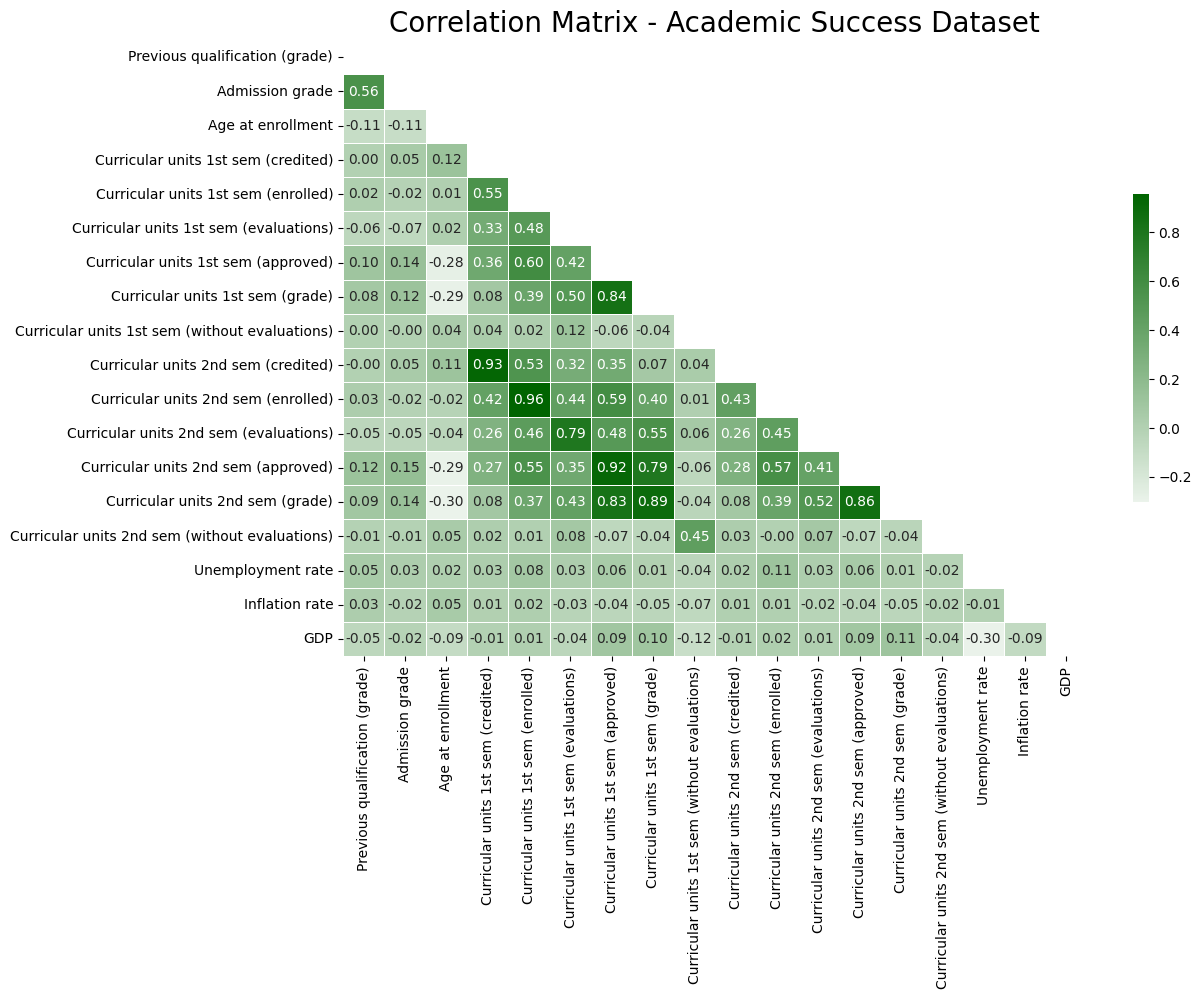

In [20]:
corr = train_data[num_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.light_palette("darkgreen", as_cmap=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title('Correlation Matrix - Academic Success Dataset', fontsize=20)

plt.savefig("Correlation Matrix.png")
plt.show()


---

# Step 2. Feature Engineering

---

In [21]:
train_data.drop(['id'], axis=1, inplace=True)
test_data.drop(['id'], axis=1, inplace=True)


In [22]:
train_data['Curricular units (credited)'] = train_data['Curricular units 1st sem (credited)'] + train_data['Curricular units 2nd sem (credited)']
train_data['Curricular units (enrolled)'] = train_data['Curricular units 1st sem (enrolled)'] + train_data['Curricular units 2nd sem (enrolled)']
train_data['Curricular units (approved)'] = train_data['Curricular units 1st sem (approved)'] + train_data['Curricular units 2nd sem (approved)']


In [23]:
test_data['Curricular units (credited)'] = test_data['Curricular units 1st sem (credited)'] + test_data['Curricular units 2nd sem (credited)']
test_data['Curricular units (enrolled)'] = test_data['Curricular units 1st sem (enrolled)'] + test_data['Curricular units 2nd sem (enrolled)']
test_data['Curricular units (approved)'] = test_data['Curricular units 1st sem (approved)'] + test_data['Curricular units 2nd sem (approved)']


In [24]:
# train_data.drop(
#     columns=[
#         'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 
#          'Curricular units 1st sem (approved)',
#         'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 
#         'Curricular units 2nd sem (approved)'
#     ], inplace=True)


In [25]:
# test_data.drop(
#     columns=[
#         'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 
#          'Curricular units 1st sem (approved)',
#         'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 
#         'Curricular units 2nd sem (approved)'
#     ], inplace=True)


---

# Step 3. Data Pre-processing

---

In [26]:
X = train_data.drop('Target', axis=1)
y = train_data['Target']


In [27]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [28]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()
cols_with_outliers = list(columns_with_outliers.index)
cols_with_no_outliers = list(columns_with_no_outliers.index)

preprocessor = ColumnTransformer(
    transformers=[
        ('robust', robust_scaler, cols_with_outliers),
        ('standard', standard_scaler, cols_with_no_outliers)
    ],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('robust', RobustScaler(),
                                 ['Previous qualification (grade)',
                                  'Admission grade', 'Age at enrollment',
                                  'Curricular units 1st sem (credited)',
                                  'Curricular units 1st sem (enrolled)',
                                  'Curricular units 1st sem (evaluations)',
                                  'Curricular units 1st sem (approved)',
                                  'Curricular units 1st sem (grade)',
                                  'Curricular units 1st sem (without '
                                  '...
                                  'Curricular units 1st sem (approved)',
                                  'Curricular units 1st sem (grade)',
                                  'Curricular units 1st sem (without '
                                  'evaluations)',
                                  'Curricular units 2nd sem (credited)',
                                  'Curricular units 2nd sem (enrolled)',
                                  'Curricular units 2nd sem (evaluations)',
                                  'Curricular units 2nd sem (approved)',
                                  'Curricular units 2nd sem (grade)',
                                  'Curricular units 2nd sem (without '
                                  'evaluations)',
                                  'Unemployment rate', 'Inflation rate',
                                  'GDP'])])


---

# Step 4. Model Training & Evaluation

---


In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.head()


In [30]:

# def xgb_objective(trial, X_train, y_train):
#     param = {
#         'verbosity': 0,
#         'objective': 'multi:softmax',
#         'num_class': len(set(y)),
#         'eval_metric': 'mlogloss',
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
#         'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
#         'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
#     }

#     if param['booster'] == 'gbtree' or param['booster'] == 'dart':
#         param['max_depth'] = trial.suggest_int('max_depth', 3, 9)
#         param['eta'] = trial.suggest_float('eta', 0.01, 0.3)
#         param['gamma'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
#         param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])

#     if param['booster'] == 'dart':
#         param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
#         param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
#         param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
#         param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

#     model = XGBClassifier(**param, use_label_encoder=False)
#     pipeline = make_pipeline(preprocessor, model)
    
#     score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    
#     return score


# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: xgb_objective(trial, X_train, y_train), n_trials=10)

# print("Best hyperparameters: ", study.best_params)


In [31]:
xgb_best_params = {'booster': 'gbtree', 'lambda': 0.7307682601434828, 'alpha': 6.221868031196627e-06, 'max_depth': 6, 'eta': 0.1595865305437521, 'gamma': 0.13412702643857463, 'grow_policy': 'lossguide'}

In [32]:
best_xgb = XGBClassifier(
#     **study.best_params,
    **xgb_best_params,
    device='gpu'
)

pipeline = make_pipeline(preprocessor, best_xgb)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

accuracy = accuracy_score(y_val, y_pred).round(4)
print("Validation Set Accuracy:", accuracy)


Validation Set Accuracy: 0.8327


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:36:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [33]:

# def lgb_objective(trial, X_train, y_train):
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 300),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'max_depth': trial.suggest_int('max_depth', -1, 50),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#     }

#     model = LGBMClassifier(**param, random_state=42)

#     pipeline = make_pipeline(preprocessor, model)
    
#     score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
    
#     return score


# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: lgb_objective(trial, X_train, y_train), n_trials=10)

# print("Best hyperparameters: ", study.best_params)


In [34]:
lgb_best_params = {'n_estimators': 266, 'learning_rate': 0.05058460730773053, 'max_depth': 21, 'num_leaves': 95, 'min_child_samples': 70, 'subsample': 0.7118244893103414, 'colsample_bytree': 0.6388926693521347}

In [35]:
best_lgb = LGBMClassifier(
#     **study.best_params,
    **lgb_best_params,
    random_state=42
)

pipeline = make_pipeline(preprocessor, best_lgb)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

accuracy = accuracy_score(y_val, y_pred).round(4)
print("Validation Set Accuracy:", accuracy)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 57
[LightGBM] [Info] Start training from score -1.105333
[LightGBM] [Info] Start training from score -1.635907
[LightGBM] [Info] Start training from score -0.746287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Validation Set Accuracy: 0.8341


In [36]:
base_learners = [
    ('XGB', best_xgb),
    ('LGB', best_lgb)
]

stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    cv=5
)

pipeline = make_pipeline(preprocessor, stacking_model)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

accuracy = accuracy_score(y_val, y_pred).round(4)
print("Validation Set Accuracy:", accuracy)

stacking_model


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 57
[LightGBM] [Info] Start training from score -1.105333
[LightGBM] [Info] Start training from score -1.635907
[LightGBM] [Info] Start training from score -0.746287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2603
[LightGBM] [Info] Number of data points in the train set: 48971, number of used features: 57
[LightGBM] [Info] Start training fr

StackingClassifier(cv=5,
                   estimators=[('XGB',
                                XGBClassifier(alpha=6.221868031196627e-06,
                                              base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device='gpu',
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eta=0.1595865305437521,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=0.13412702643857463,...
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, ...)),
                               ('LGB',
                                LGBMClassifier(colsample_bytree=0.6388926693521347,
                                               learning_rate=0.05058460730773053,
                                               max_depth=21,
                                               min_child_samples=70,
                                               n_estimators=266, num_leaves=95,
                                               random_state=42,
                                               subsample=0.7118244893103414))],
                   final_estimator=LogisticRegression())

---

# Step 5. Make Predictions on Test Data

---

In [37]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stacking_model)
])

test_predictions = pipeline.predict(test_data)    


In [38]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')

sample_submission['Target'] = test_predictions
sample_submission['Target'] = label_encoder.inverse_transform(sample_submission['Target'])

sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(5)


,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled


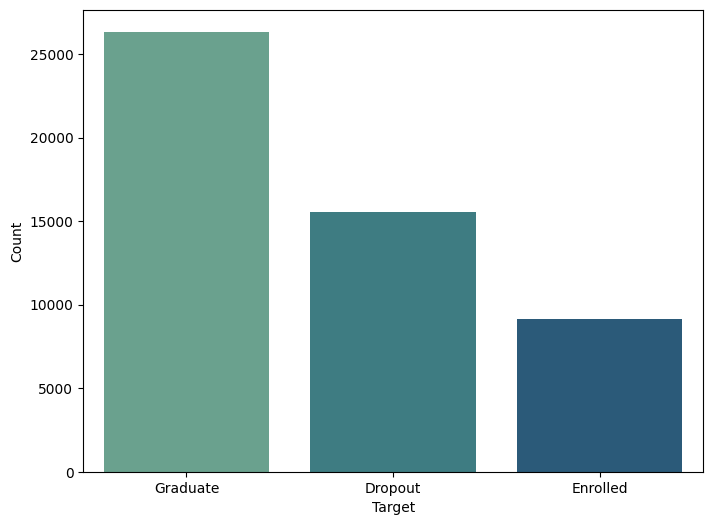

In [39]:
target_counts = sample_submission['Target'].value_counts()

plt.figure(figsize=(8,6))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='crest')
plt.ylabel('Count')
plt.show()
